In [1]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pandas as pd
from sklearn.metrics import r2_score
from keras import backend as K
from platypus import SMPSO, Problem, Real, NSGAII, MOEAD
import pickle
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
from sklearn.ensemble import RandomForestRegressor


In [4]:
from problem import TBE
import visualization 


In [5]:
rent_model = pickle.load(open('../model_creation/outputs/rent_models/random_forest.pkl', 'rb'))
sale_model = pickle.load(open('../model_creation/outputs/sale_models/random_forest.pkl', 'rb'))

In [18]:
problem = ROI(rent_model, sale_model)

algorithm = SMPSO(problem, log_frequency=100)
algorithm.run(5000)

In [19]:
print(algorithm.result[0])
print(algorithm.result[0].objectives)

Solution[1120.4829690215952,2.994582577570575,1.4772797501091945,11368.0,18705.54734819749|27.358165042131176|0]
[27.358165042131176]


In [20]:
objectives = [list(row.objectives) for row in algorithm.result]
parameters = [list(row.variables) for row in algorithm.result]

In [21]:
def predict_prices(parameters):
    rent_price = pd.DataFrame(rent_model.predict(parameters),columns=['rental'])
    sale_price = pd.DataFrame(sale_model.predict(parameters),columns=['sale'])
    return pd.concat([rent_price, sale_price], axis=1)

In [22]:
objectives = pd.DataFrame(objectives, columns=['ROI'])
parameters = pd.DataFrame(parameters, columns=['sqfeet','beds','baths','income','density'])
parameters['beds'] = parameters['beds'].astype(int)
parameters['baths'] = parameters['baths'].astype(int)

In [23]:
objectives = pd.concat([objectives, predict_prices(parameters)], axis=1)

In [24]:
optimized_data = pd.concat([parameters, objectives], axis=1)

In [25]:
optimized_data

,sqfeet,beds,baths,income,density,ROI,rental,sale
0,1120.482969,2,1,11368.0,18705.547348,27.358165,2147.76,73486.0


In [26]:
optimized_data.describe()

,sqfeet,beds,baths,income,density,ROI,rental,sale
count,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.00,1.0
mean,1120.482969,2.0,1.0,11368.0,18705.547348,27.358165,2147.76,73486.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1120.482969,2.0,1.0,11368.0,18705.547348,27.358165,2147.76,73486.0
25%,1120.482969,2.0,1.0,11368.0,18705.547348,27.358165,2147.76,73486.0
50%,1120.482969,2.0,1.0,11368.0,18705.547348,27.358165,2147.76,73486.0
75%,1120.482969,2.0,1.0,11368.0,18705.547348,27.358165,2147.76,73486.0
max,1120.482969,2.0,1.0,11368.0,18705.547348,27.358165,2147.76,73486.0


(<Figure size 504x360 with 1 Axes>,
 <AxesSubplot:xlabel='Rent price', ylabel='Sale price'>)

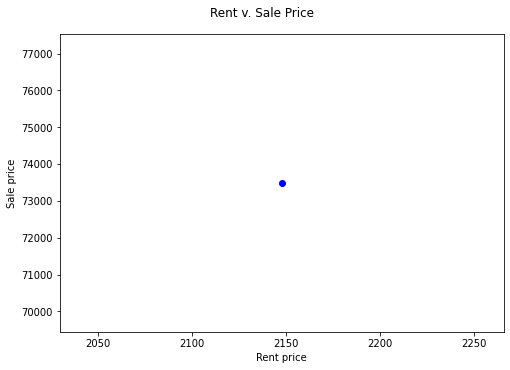

In [27]:
visualization.plot_pareto_front(optimized_data, "Rent v. Sale Price")

(<Figure size 1800x720 with 10 Axes>,
 array([[<AxesSubplot:xlabel='sqfeet', ylabel='beds'>,
         <AxesSubplot:xlabel='sqfeet', ylabel='income'>,
         <AxesSubplot:xlabel='beds', ylabel='baths'>,
         <AxesSubplot:xlabel='beds', ylabel='density'>,
         <AxesSubplot:xlabel='baths', ylabel='density'>],
        [<AxesSubplot:xlabel='sqfeet', ylabel='baths'>,
         <AxesSubplot:xlabel='sqfeet', ylabel='density'>,
         <AxesSubplot:xlabel='beds', ylabel='income'>,
         <AxesSubplot:xlabel='baths', ylabel='income'>,
         <AxesSubplot:xlabel='income', ylabel='density'>]], dtype=object))

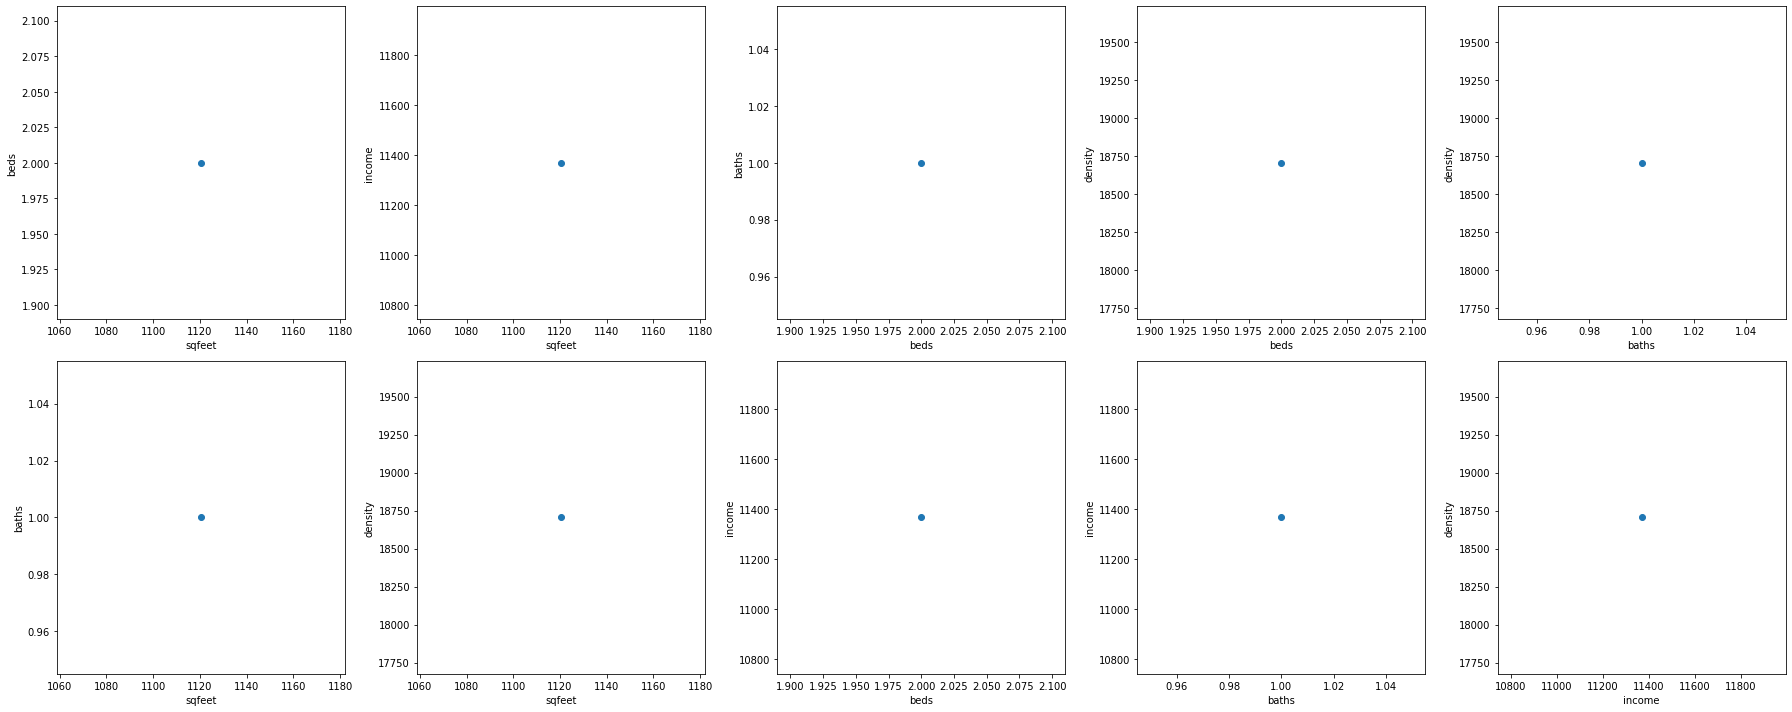

In [28]:
visualization.plot_input_distributions(optimized_data)

In [29]:
optimized_data.to_csv('./outputs/roi/smpso.csv')